## Apple Health Processor

-----

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

------

## Steps

In [2]:
steps = pd.read_csv("data/StepCount.csv")

In [3]:
# steps.head()

### Correct time zone to EST and capture time properties

In [4]:
# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['year_month'] = steps['startDate'].dt.strftime('%Y-%m')
steps['year'] = steps['startDate'].dt.year
steps['month'] = steps['startDate'].dt.month
steps['day'] = steps['startDate'].dt.day
steps['hour'] = steps['startDate'].dt.hour
steps['dow'] = steps['startDate'].dt.weekday
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate'], axis=1)

In [5]:
# steps.head()
# steps.columns

### Use Only Watch Steps, Remove Phone Steps

In [6]:
# drop phone steps ---NEED TO CHANGE THIS TO KEEP PHONE STEPS BEFORE THE WATCH
steps = steps[steps.sourceName == 'Greg’s Apple\xa0Watch']
steps.tail()

,sourceName,sourceVersion,type,unit,startDate,endDate,value,date,year_month,year,month,day,hour,dow,doy
106895,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:43:16-05:00,2020-04-14 17:44:15-05:00,44,2020-04-14,2020-04,2020,4,14,17,1,105
106896,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:44:15-05:00,2020-04-14 17:44:51-05:00,38,2020-04-14,2020-04,2020,4,14,17,1,105
106897,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:45:27-05:00,2020-04-14 17:45:42-05:00,34,2020-04-14,2020-04,2020,4,14,17,1,105
106898,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:47:32-05:00,2020-04-14 17:48:26-05:00,18,2020-04-14,2020-04,2020,4,14,17,1,105
106899,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:49:22-05:00,2020-04-14 17:49:27-05:00,5,2020-04-14,2020-04,2020,4,14,17,1,105


### Merge Fitbit data

In [7]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
# fb['endDate'] = pd.to_datetime(fb['endDate'], utc=True).dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
fb['year'] = fb['Date'].dt.year
fb['month'] = fb['Date'].dt.month
fb['day'] = fb['Date'].dt.day
# fb['hour'] = fb['startDate'].dt.hour
fb['dow'] = fb['Date'].dt.weekday
fb['doy'] = fb['Date'].dt.dayofyear

# #drop irrelevant columns
# fb = fb.drop(['Date', 'Calories Burned', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active','Activity Calories'], axis=1)

fb2=fb[['date', 'Steps']]
#drop rows that overlap apple watch
fb2=fb2.iloc[:-2,:]

# fb.head()
fb2.tail()

,date,Steps
588,2018-06-12,10456
589,2018-06-13,15527
590,2018-06-14,17421
591,2018-06-15,12739
592,2018-06-16,13740


-----

## Merge Fitbit Data

In [8]:
# Aggregate apple watch data by date
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_date = pd.concat([fb2, steps_by_date], ignore_index=True)

# print(steps_by_date.head())
# print(steps_by_date.tail())

In [9]:
steps_by_date['RollingMeanSteps'] = steps_by_date.Steps.rolling(window=7, center=True).mean()

steps_by_date=steps_by_date.dropna(axis=0)
steps_by_date['date']=pd.to_datetime(steps_by_date['date'])

# print(steps_by_date.head(10))

### Rolling average

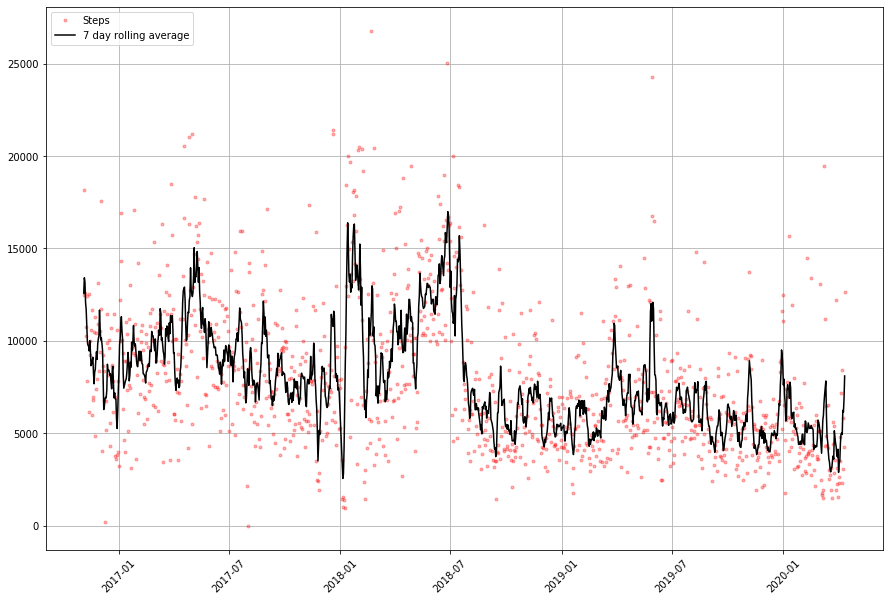

In [10]:
steps_by_date2=steps_by_date.set_index('date')

plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.3,label='Steps')
plt.plot(steps_by_date2['RollingMeanSteps'], c='k',label='7 day rolling average')
plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

In [11]:
# #Write df to csv
# steps_by_date.to_csv("data/steps_per_day.csv", index=False)

------

## Monthly Steps

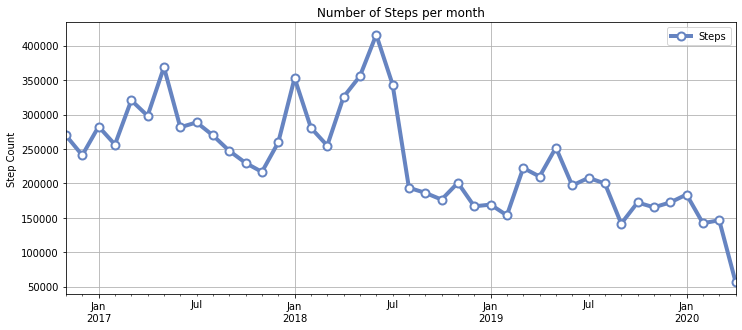

In [12]:
df = steps_by_date.drop('RollingMeanSteps', axis=1)
df = df.resample('M', on='date').sum()
# df.head()

chart_title = 'Number of Steps per month'

ax = df.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()

In [13]:
# total_steps_by_month = steps.groupby(['year','month'])['value'].sum().reset_index(name='Steps')

In [14]:
# total_steps_by_month

## Steps By Year

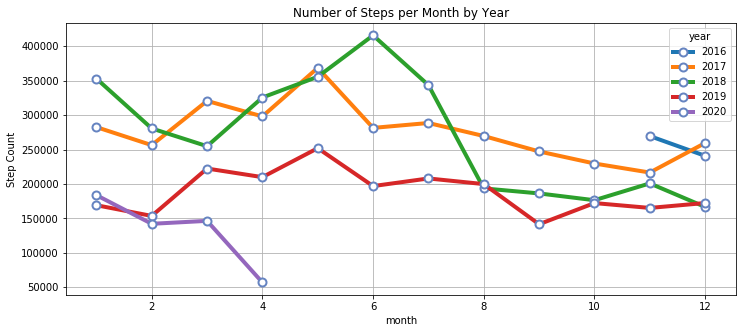

In [15]:
# Group data by year in pivot table
df2 = steps_by_date.drop(['RollingMeanSteps'], axis=1)
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
df3.head()
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

plt.show()

----

-----

## Weight Data

In [16]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

# drop duplicates
weight.drop_duplicates(subset = 'date', keep='last', ignore_index=True, inplace=True)

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [17]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [18]:
#merge with fitbit data
# print(weight.shape)
weight = pd.concat([weight2,weight], ignore_index=True)
# print(weight.shape)

(1110, 1)


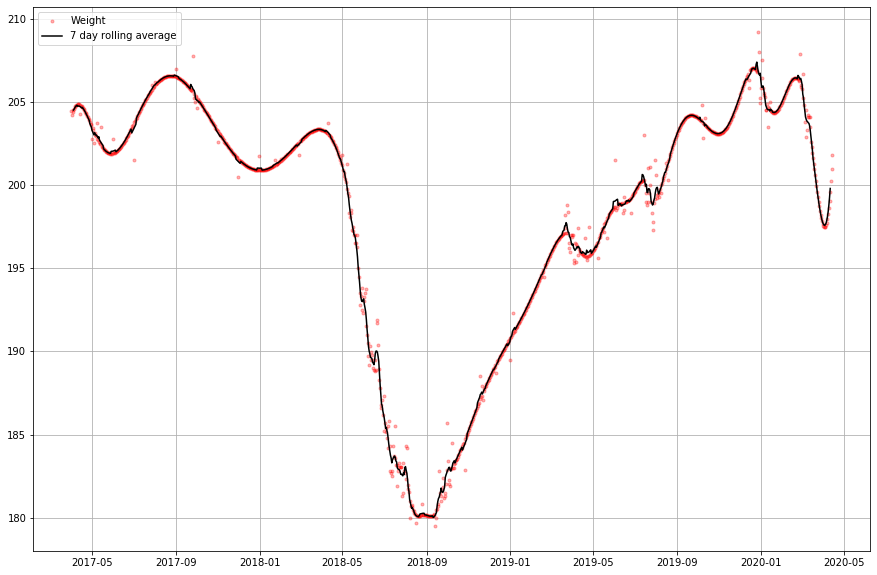

In [19]:
# parse out date and time elements
weight['Date'] = pd.to_datetime(weight['date'])
# weight['year_month'] = weight['Date'].dt.strftime('%Y-%m')
# weight['year'] = weight['Date'].dt.year
# weight['month'] = weight['Date'].dt.month
# weight['day'] = weight['Date'].dt.day

#sort by date and reindex
weight = weight.sort_values(by='Date', ignore_index=True)

#set Date as index
weight = weight.drop('date', axis=1).set_index('Date')

# print(weight.head(10))
# print(weight.shape)

#resample by day and interpolate missing values using splines
weight = weight.resample('D').interpolate(method='spline', order = 5, axis = 0)
print(weight.shape)

#create a 7day rolling average
weight['rolling_avg']=weight.rolling(window=7, center=True).mean()


weight.head(10)



# steps_by_date['RollingMeanSteps'] = steps_by_date.Steps.rolling(window=7, center=True).mean()
# steps_by_date2=steps_by_date.set_index('date')

plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(weight['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight['rolling_avg'], c='k',label='7 day rolling average')
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

# print(weight.head(10))
# reindex
# resample

In [20]:
weight.tail()

,Weight,rolling_avg
Date,,
2020-04-10,199.061006,199.241551
2020-04-11,199.601248,199.790589
2020-04-12,200.238057,NaN
2020-04-13,200.978076,NaN
2020-04-14,201.800000,NaN


In [21]:
month_weight = weight.groupby(['month'])['value'].mean().reset_index(name='Weight')

KeyError: 'month'

In [ ]:
month_weight

In [ ]:
# a bit of a hackish solution, could use improvement
dataset = month_weight
chart_title = 'Monthly Weight'

n_groups = len(dataset)
index = np.arange(n_groups)

ax = dataset.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

# ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
# ax.set_ylim(0, 1000)
ax.set_xticks(index)
ax.set_ylabel('Weight (lbs)')
plt.xticks(index, dataset.month, rotation=90)
ax.set_title(chart_title)

plt.show()

In [ ]:
# # convert to kg
# month_weight['kg'] = round(month_weight['Weight'] / 2.205, 2)

In [ ]:
# month_weight.columns

In [ ]:
# # a bit of a hackish solution, could use improvement
# dataset = month_weight[['month', 'kg']]
# chart_title = 'Monthly Weight'

# n_groups = len(dataset)
# index = np.arange(n_groups)

# ax = dataset.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
#                       markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

# # ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

# ax.yaxis.grid(True)
# ax.xaxis.grid(True)
# # ax.set_ylim(0, 1000)
# ax.set_xticks(index)
# ax.set_ylabel('Weight (kg)')
# plt.xticks(index, dataset.month, rotation=90)
# ax.set_title(chart_title)

# plt.show()

## Heart Rate

In [ ]:
resting = pd.read_csv("data/RestingHeartRate.csv")
len(resting)

In [ ]:
resting.columns

In [ ]:
resting.sourceName.unique()

In [ ]:
# # parse out date and time elements as EST time
# resting['startDate'] = pd.to_datetime(resting['startDate'])
# resting['year'] = resting['startDate'].map(get_year)
# resting['month'] = resting['startDate'].map(get_month)
# resting['date'] = resting['startDate'].map(get_date)

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['endDate'] = pd.to_datetime(resting['endDate'], utc=True).dt.tz_convert('EST')
resting['year'] = resting['startDate'].dt.year
resting['month'] = resting['startDate'].dt.strftime('%Y-%m')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')
resting['day'] = resting['startDate'].dt.day
resting['hour'] = resting['startDate'].dt.hour
resting['dow'] = resting['startDate'].dt.weekday

resting.drop(['device', 'creationDate'], axis=1)

In [ ]:
# resting.tail(10)

In [ ]:
resting[resting.month == '2019-08'].plot(x='date', y='value', title= 'Resting HR', figsize=[10, 6])

In [ ]:
hr = pd.read_csv("data/HeartRate.csv")
len(hr)

In [ ]:
# hr.tail(10)

In [ ]:
# # parse out date and time elements as EST time
# hr['startDate'] = pd.to_datetime(hr['startDate'])
# hr['year'] = hr['startDate'].map(get_year)
# hr['month'] = hr['startDate'].map(get_month)
# hr['hour'] = hr['startDate'].map(get_hour)
# hr['date'] = hr['startDate'].map(get_date)


# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
hr['endDate'] = pd.to_datetime(hr['endDate'], utc=True).dt.tz_convert('EST')
hr['year'] = hr['startDate'].dt.year
hr['month'] = hr['startDate'].dt.strftime('%Y-%m')
hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')
hr['day'] = hr['startDate'].dt.day
hr['hour'] = hr['startDate'].dt.hour
hr['dow'] = hr['startDate'].dt.weekday

hr.drop(['device', 'creationDate'], axis=1)

In [ ]:
# plot a single day
test_date = '2019-08-28'
# len(hr[hr.date == test_date])
# TODO: Fix Axis for Hour of Day or Something Similar
hr[hr.date == test_date].plot(x='startDate', y='value', title= 'HR', figsize=[10, 6])

------